In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import neuron
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 4.3),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
#         'xtick.labelsize':'x-large',
#         'ytick.labelsize':'x-large'
         }
pylab.rcParams.update(params)
nrn = neuron.h

In [3]:
def steady_state():
# Used SI-units here
    x = np.linspace(0,5.0e-3,5000)
    d = 1e-6
    Ra = 0.354
    Rm = 1
    lc = (d*Rm/4/Ra)**(0.5)
    Em = -70e-3
    Ie = 0.1e-9 # 100 pA
    Rinf = np.sqrt(Rm*Ra*4/np.pi**2/d**3)
    phi = Em+Rinf*Ie*np.exp(-x/lc)
    return x, phi

In [4]:
def return_stick():
    """
    Makes a stick cable model.
    """
    dend = nrn.Section('dend')
    dend.L = 1000 # mum
    dend.diam = 1 # mum
    dend.nseg = int(dend.L/10)

    Rm = 10000 # Ohm*cm2

    for sec in nrn.allsec():
        sec.insert('pas')
        sec.Ra = 35.4 # Ohm*cm
        sec.cm = 1
        for seg in sec:
            seg.g_pas = 1/Rm
            seg.e_pas = -70 # mV
    return dend

In [5]:
def insert_current_clamp(input_site):
    """
    Inserts a current clamp in the neuron model
    :param input_site: Where to place the current clamp. Example: soma(0.5), where 0.5 means 'center',
           0 would mean start, and 1 would mean at the end of the segment in question.
    :return: The NEURON object current clamp. This must be returned, otherwise it is lost.
    """
    stim = nrn.IClamp(input_site)
    stim.delay = 10
    stim.amp = 0.0113
    stim.dur = 1e9
    return stim

In [6]:
def insert_synapse(input_site):
    """
    Inserts a current clamp in the neuron model
    :param input_site: Where to place the current clamp. Example: soma(0.5), where 0.5 means 'center',
           0 would mean start, and 1 would mean at the end of the segment in question.
    :return: The NEURON object current clamp. This must be returned, otherwise it is lost.
    """
    asyn = nrn.AlphaSynapse(input_site)
    asyn.onset = 10
    asyn.gmax = 0.1
#    asyn = nrn.Exp2Syn(input_site)
#    asyn.onset = 10
#    asyn.tau1 = 0.5
#    asyn.tau2 = 1
#    asyn.e = 0
#    asyn.i = 100
    return asyn

In [7]:
def run_simulation(record_site):
    """
    Runs the NEURON simulation
    :param record_site: Where to record membrane potential from. Example: soma(0.5), where 0.5 means 'center',
           0 would mean start, and 1 would mean at the end of the segment in question.
    :return: Time and voltage numpy arrays
    """
    rec_t = nrn.Vector()
    rec_t.record(nrn._ref_t)
    rec_v = nrn.Vector()
    rec_v.record(record_site._ref_v)
    neuron.h.dt = 2**-3
    nrn.finitialize(-70)
    neuron.init()
    neuron.run(30)
    return np.array(rec_t), np.array(rec_v)

In [10]:
def cablesim():
    x,phi = steady_state()
    exp_t = np.load('exp_t.npy')
    exp_v = np.load('exp_v.npy')

    dend = return_stick()
    stim = insert_synapse(dend(0))
    t1, v1 = run_simulation(dend(0))
    t2, v2 = run_simulation(dend(0.25))
    t3, v3 = run_simulation(dend(0.5))
    t4, v4 = run_simulation(dend(0.75))

#    fig = plt.figure(figsize=(11,5))
    fig = plt.figure()
    ax0 = fig.add_subplot(121, xlabel="x [mm]", ylabel="V [mV]")
    ax1 = fig.add_subplot(122, xlabel="Time [ms]", ylabel="V [mV]")
    
    ax0.plot(1000*x,1000*phi,'g',label='steady state')

#    ax1.plot(t, exp_v, 'gray', label='"Experiment"')
    ax1.plot(t1, v1, 'g', label='0 mm')
    ax1.plot(t2, v2, 'b', label='0.25 mm')
    ax1.plot(t3, v3, 'r', label='0.5 mm')
    ax1.plot(t4, v4, 'k', label='0.75 mm')

    legend(loc=1, frameon=False)

    savefig('cablesims.png')

<IPython.core.display.Javascript object>


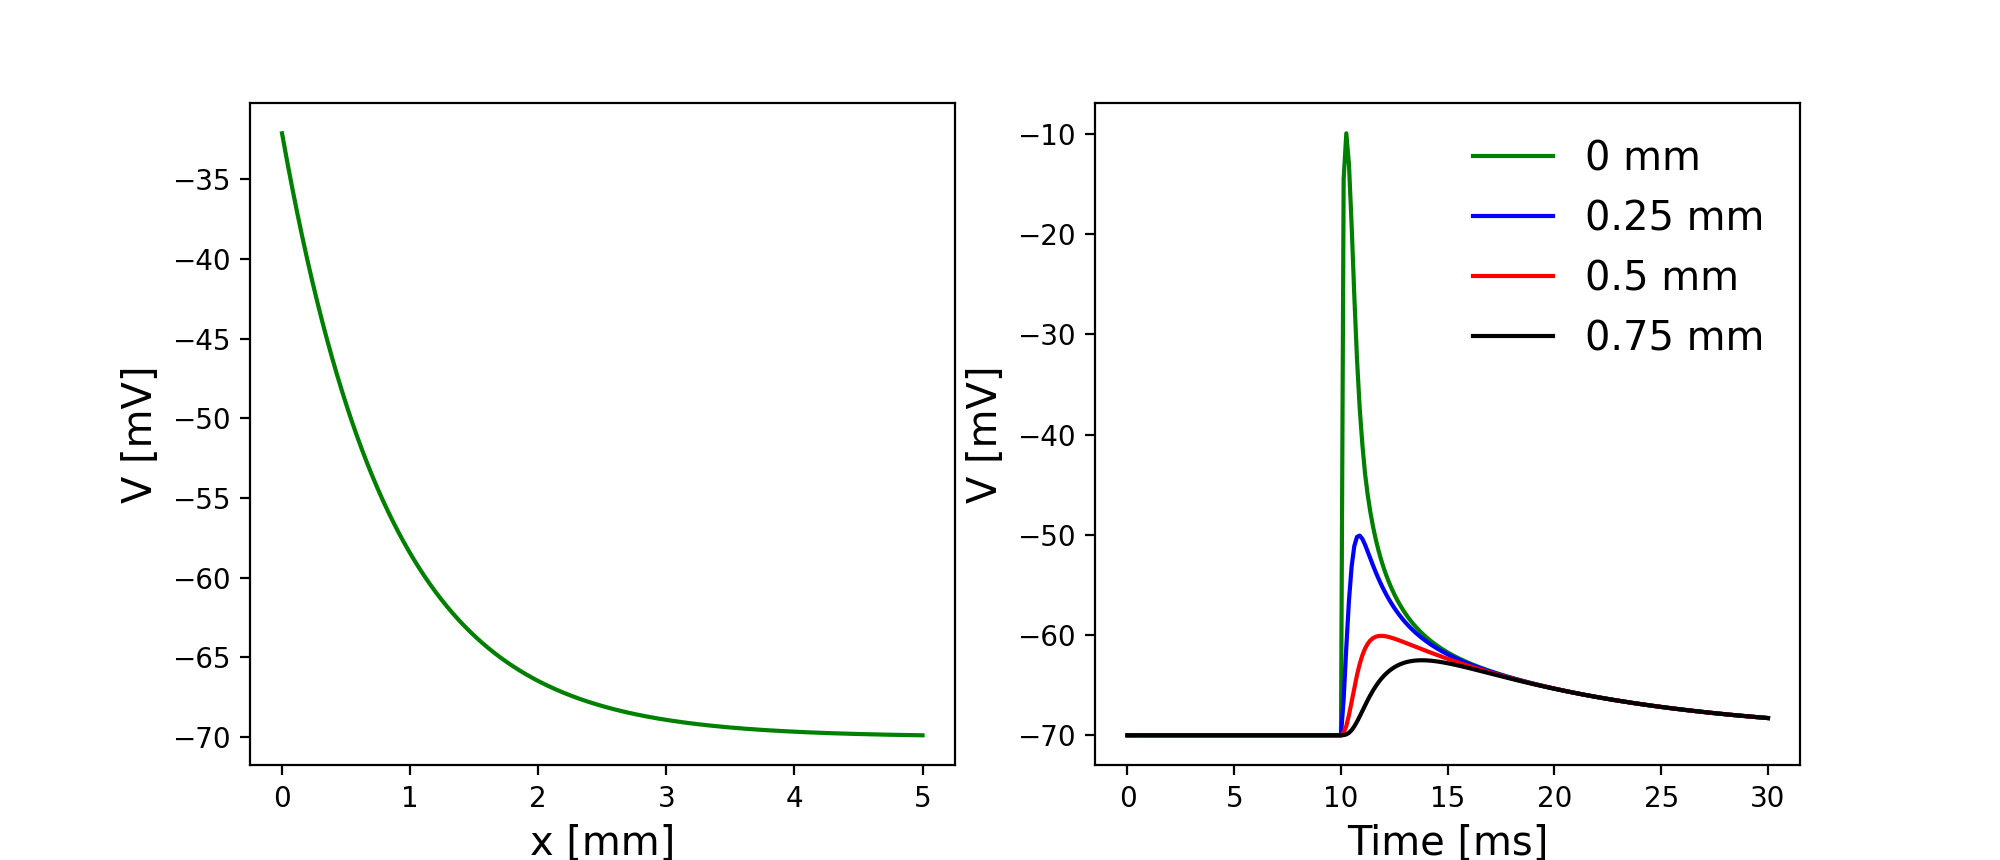

In [11]:
close('all')
cablesim()

In [ ]:
close()